**Let's have a look at shopping cart data**

In [39]:
import pandas as pd
from scipy.stats import zscore
import numpy as np
CartData = pd.read_csv('cart.csv',parse_dates=['date'])

In [40]:
CartData

,date,name,amount,price
0,2021-03-01,carrot,7.0,5.73
1,2021-03-01,egg,12.0,1.70
2,2021-03-01,milk,NaN,3.57
3,2021-03-01,potato,2.0,NaN
4,NaT,tomato,6.0,1.52
5,2021-03-02,potato,3.0,2.17
6,2021-03-03,NaN,5.0,3.68


As you can see, we have a lot of missing data here! Now, what's even more interesting is that the "amount" column is a float. To make sure, let's take a look at the data types.

In [41]:
CartData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6 non-null      datetime64[ns]
 1   name    6 non-null      object        
 2   amount  6 non-null      float64       
 3   price   6 non-null      float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 352.0+ bytes


In [42]:
CartData.dtypes

date      datetime64[ns]
name              object
amount           float64
price            float64
dtype: object

**Now we want to see which data are null and how many of them are null.**

In [43]:
CartData.isnull()

,date,name,amount,price
0,False,False,False,False
1,False,False,False,False
2,False,False,True,False
3,False,False,False,True
4,True,False,False,False
5,False,False,False,False
6,False,True,False,False


In [44]:
CartData.isnull().sum()

date      1
name      1
amount    1
price     1
dtype: int64

**Your data will have bad values.When I say bad, I mean data that was generated by error. **

In [45]:
MetricsData = pd.read_csv('metrics.csv')

In [46]:
MetricsData

,time,name,value
0,2021-07-13 14:36:52.380,mem,2.275172e+08
1,2021-07-13 14:36:52.380,cpu,3.157000e+01
2,2021-07-13 14:36:53.337,mem,2.275192e+08
3,2021-07-13 14:36:53.337,cpu,3.009000e+02
4,2021-07-13 14:36:54.294,mem,2.275157e+08
...,...,...,...
95,2021-07-13 14:37:37.359,mem,2.274985e+08
96,2021-07-13 14:37:38.316,cpu,3.507000e+01
97,2021-07-13 14:37:38.316,mem,2.274929e+08
98,2021-07-13 14:37:39.273,mem,2.274967e+08


***Let's use groupby to have a look at statistics per metric.So let's run the cell, groupby name and describe.And we see that the CPU has one count with the mean,and we see that minus 32.14 is probably an errorfor a metric value, either CPU or memory.***

In [47]:
MetricsData.groupby('name').describe()

value                                                                  \
     count          mean           std     min           25%           50%   
name                                                                         
CPU    1.0  3.040000e+01           NaN   30.40  3.040000e+01  3.040000e+01   
cpu   49.0  3.645633e+01  3.977927e+01  -32.14  2.956000e+01  3.157000e+01   
mem   50.0  2.229711e+08  3.217637e+07  295.00  2.275070e+08  2.275188e+08   

                                 
               75%          max  
name                             
CPU   3.040000e+01         30.4  
cpu   3.507000e+01        300.9  
mem   2.275342e+08  227556054.0

***The value count method is a great wayto find problems in categorical data such as the name.So let's run df name, values count.And we say we have 50 of memory,but 49 of cpu with a lowercase,and a single CPU with the uppercase.Some people find it easier to spot bad values on a chart.***

In [48]:
MetricsData['name'].value_counts()

name
mem    50
cpu    49
CPU     1
Name: count, dtype: int64

array([<Axes: xlabel='time'>, <Axes: xlabel='time'>,
       <Axes: xlabel='time'>], dtype=object)

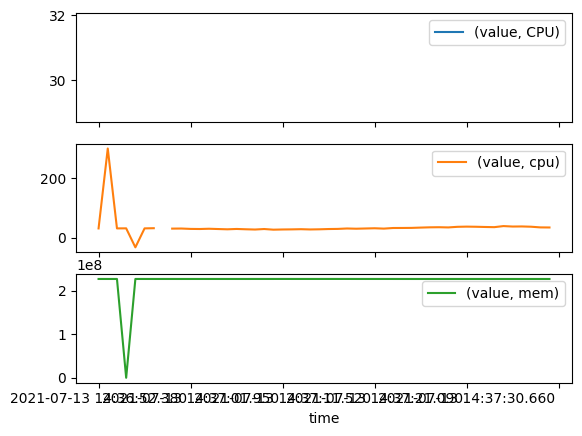

In [49]:
#In my opinion, it wouldn't hurt to have a visual look at the data. This way, we can grasp more information(=.
pd.pivot(MetricsData, index='time', columns='name').plot(subplots=True)

In [50]:
#As you can see, by dragging the data to a more graphical environment, we were able to identify a problem.
MetricsData.query('name == "cpu" & (value < 0 | value > 100)')

,time,name,value
3,2021-07-13 14:36:53.337,cpu,300.90
9,2021-07-13 14:36:56.208,cpu,-32.14


This code executes a query on a DataFrame named MetricsData. The query is as follows:

```python
MetricsData.query('name == "cpu" & (value < 0 | value > 100)')
```

This query finds the rows in the DataFrame where the value in the 'name' column is equal to "cpu" and the value in the 'value' column is less than zero or greater than 100.

For example, suppose our data is as follows:

| name | value |
|------|-------|
| cpu  | 50    |
| cpu  | -10   |
| cpu  | 120   |
| mem  | 80    |

After running the query, the following rows will be returned as a result:

| name | value |
|------|-------|
| cpu  | -10   |
| cpu  | 120   |

Thus, using this query, we can find the two problematic rows whose 'value' column is less than zero or greater than 100.

In [51]:
mem=MetricsData[MetricsData['name']=='mem']['value']
z_score = (mem-mem.mean())/mem.std()
bad_mem =  mem[z_score.abs()>2]
MetricsData.loc[bad_mem.index]

,time,name,value
6,2021-07-13 14:36:55.251,mem,295.0


In [52]:
mem=MetricsData[MetricsData['name']=='mem']
Z_score=zscore(mem['value'])
MetricsData.loc[Z_score[Z_score<0].index]

,time,name,value
6,2021-07-13 14:36:55.251,mem,295.0


***<h1>--Duplicates--</h1>***

***Duplicate data will makeyour calculations go wrong.Even worse, if you process the same transaction twice,you're going to lose a customer.Let's have a look at the shopping cart data.***

In [53]:
import pandas as pd

In [54]:
CartData

,date,name,amount,price
0,2021-03-01,carrot,7.0,5.73
1,2021-03-01,egg,12.0,1.70
2,2021-03-01,milk,NaN,3.57
3,2021-03-01,potato,2.0,NaN
4,NaT,tomato,6.0,1.52
5,2021-03-02,potato,3.0,2.17
6,2021-03-03,NaN,5.0,3.68


***Pandas come with a duplicated method. Let's run it.And you see it's going to catch only the last two.***

In [55]:
import pandas as pd

# Create a sample DataFrame with duplicate values
data = pd.DataFrame({
   'name': ['John', 'Emily', 'John', 'Jane', 'John'],
   'age': [25, 28, 25, 30, 25],
   'salary': [50000, 60000, 50000, 70000, 50000]
})

# Identify duplicate rows
duplicates = data.duplicated()

# Print the duplicate rows
print(data[duplicates])
duplicates

   name  age  salary
2  John   25   50000
4  John   25   50000


0    False
1    False
2     True
3    False
4     True
dtype: bool

In [56]:
# Drop duplicate rows
data = data.drop_duplicates()
# Print the updated DataFrame
print(data)

    name  age  salary
0   John   25   50000
1  Emily   28   60000
3   Jane   30   70000


***<h1>Finding missing data</h1>***

**in some cases, some features will be missing.Missing data can come from users refusingto answer a question or data that is missing a featureand other reasons.Let's have a look at our shipping data**

In [57]:
ShipData = pd.read_csv('ships.csv')
ShipData2 = pd.read_csv('ships-null2.csv')
ShipData

,name,lat,lng
0,Black Pearl,20.664865,-80.709747
1,Cobra,20.664868,-80.709740
2,Flying Dutchman,20.664878,-80.709941
3,Empress,NaN,NaN


In [58]:
ShipData[ShipData.isnull().any(axis=1)]

,name,lat,lng
3,Empress,NaN,NaN


In [59]:
#Alright! As you can see, dear friends, we cannot find an empty string data, but we can do it with this method.
ShipData2[ShipData2.isnull().any(axis=1)]

,name,lat,lng
3,Empress,NaN,NaN


In [60]:
ShipData2[ShipData2['name'] == ' '] = np.nan

In [61]:
ShipData2[ShipData2.isnull().any(axis=1)]

,name,lat,lng
3,Empress,NaN,NaN
4,NaN,NaN,NaN


In [62]:
# ok i want show some method can help to you'r self
data = {
    'A': [1, 2, np.nan, 4, 5], 
    'B': [np.nan, 2, 3,np.nan , 5], 
    'C': [1, '', 3,np.nan , 5], 
    'D': [1, 2, 3, 4, ''],
    'e': [1, 2, np.nan, 4, 5], 
    'f': [np.nan, 2, 3,np.nan , 5], 
    'g': [1, '', np.nan,np.nan , 5], 
    'h': [1, '', 3, 4, ''],
    'A': [1, 2, np.nan, 4, 5]
}
data = pd.DataFrame(data)

In [63]:
data.isnull().sum()

A    1
B    2
C    1
D    0
e    1
f    2
g    2
h    0
dtype: int64

In [64]:
print(data.isnull().sum().sum())
data

9


,A,B,C,D,e,f,g,h
0,1.0,NaN,1,1,1.0,NaN,1,1
1,2.0,2.0,,2,2.0,2.0,,
2,NaN,3.0,3,3,NaN,3.0,NaN,3
3,4.0,NaN,NaN,4,4.0,NaN,NaN,4
4,5.0,5.0,5,,5.0,5.0,5,


In [65]:
data[data['h']==''] = np.nan
data[data.isnull().any(axis=1)]

,A,B,C,D,e,f,g,h
0,1.0,NaN,1,1,1.0,NaN,1,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,3.0,3,3,NaN,3.0,NaN,3
3,4.0,NaN,NaN,4,4.0,NaN,NaN,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [66]:
data.isnull().sum().sum()

25

In [71]:
data=data.dropna(how='all')

In [72]:
data

,A,B,C,D,e,f,g,h
0,1.0,NaN,1,1,1.0,NaN,1,1
2,NaN,3.0,3,3,NaN,3.0,NaN,3
3,4.0,NaN,NaN,4,4.0,NaN,NaN,4


In [74]:
data.isnull().sum().sum()

9